# Model Understanding with Captum

In [2]:
%pip install torch torchvision captum matplotlib Flask-Compress

  Using cached torch-2.8.0-cp310-none-macosx_11_0_arm64.whl.metadata (30 kB)
  Using cached torchvision-0.23.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (6.1 kB)
  Using cached captum-0.8.0-py3-none-any.whl.metadata (26 kB)
  Using cached matplotlib-3.10.6-cp310-cp310-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached flask_compress-1.18-py3-none-any.whl.metadata (9.2 kB)
  Using cached filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached numpy-2.2.6-cp310-cp310-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached pillow-11.3.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (9.0 kB)
  Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl.metadata (61 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
 

## A first example

We’ll start with a ResNet model pretrained on the ImageNet dataset. We’ll get a test input, and use different Feature Attribution algorithms to examine how the input images affect the output, and see a helpful visualization of this input attribution map for some test images.



In [1]:
print("Hello World")

Hello World


In [2]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models



import os,sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [3]:
import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

In [4]:
model = models.resnet18(weights='IMAGENET1K_V1')
model = model.eval()

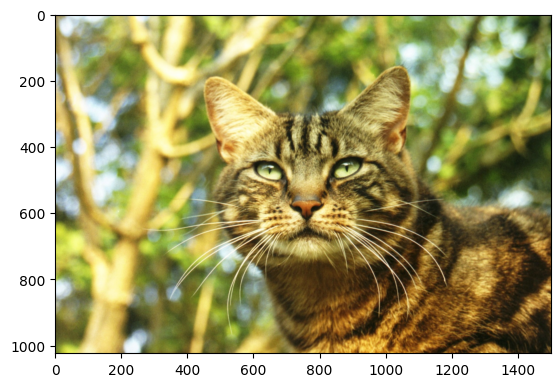

In [5]:
test_img = Image.open('img/cat.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()

In [6]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Standard ImageNET normalization
transform_normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225]
)

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0)

labels_path = 'img/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

In [10]:
output = model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted_label: ', predicted_label, '(', prediction_score.squeeze().item(), ')' )

Predicted_label:  tabby ( 0.5688215494155884 )


## Feature Attribution with Integrated Graphics

- Integrated Gradients assigns an importance score to each input feature by approximating the integral of the gradients of the model’s output with respect to the inputs.

- In our case, we’re going to be taking a specific element of the output vector - that is, the one indicating the model’s confidence in its chosen category - and use Integrated Gradients to understand what parts of the input image contributed to this output.

- Once we have the importance map from Integrated Gradients, we’ll use the visualization tools in Captum to give a helpful representation of the importance map. Captum’s visualize_image_attr() function provides a variety of options for customizing display of your attribution data. Here, we pass in a custom Matplotlib color map.



/Users/qbit-glitch/Desktop/coding-projects/pytorch_tutorials_from_official_docs/venv_2/lib/python3.10/site-packages/captum/attr/_utils/visualization.py:110: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  return _normalize_scale(attr_combined, threshold)


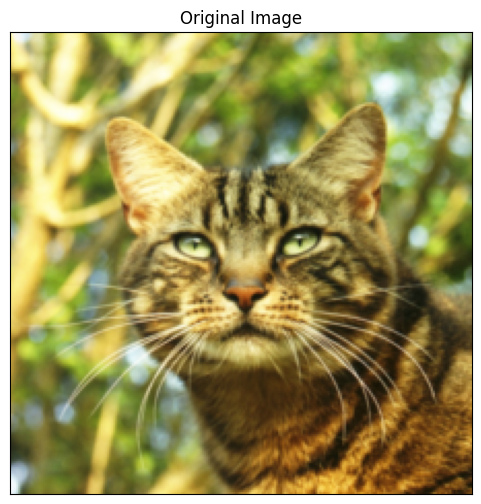

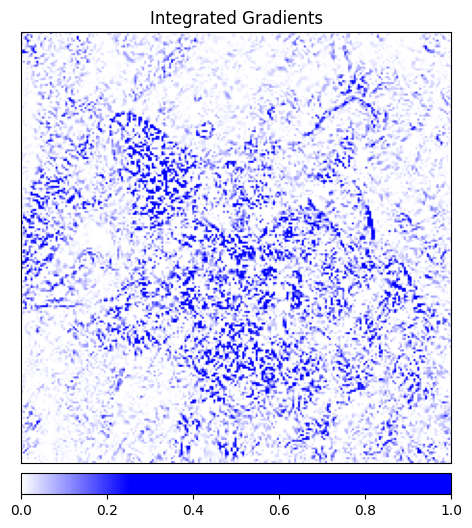

In [14]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

# Ask the algorithm to attribute our output target to
attributions_ig = integrated_gradients.attribute(input_img, target=pred_label_idx, n_steps=200)

# Create dummy attributions (all zeros) with the same shape as the image
dummy_attr = np.ones_like(np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0))) * 1e-6

_ = viz.visualize_image_attr(
    dummy_attr,
    np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
    method="original_image",
    title="Original Image"
)

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')


## Feature Attribution with Occlusion

- Gradient-based attribution methods help to understand the model in terms of directly computing out the output changes with respect to the input. Perturbation-based attribution methods approach this more directly, by introducing changes to the input to measure the effect on the output. Occlusion is one such method. It involves replacing sections of the input image, and examining the effect on the output signal.

- We’ll visualize the output of our Occlusion attribution with visualize_image_attr_multiple(), showing heat maps of both positive and negative attribution by region, and by masking the original image with the positive attribution regions. The masking gives a very instructive view of what regions of our cat photo the model found to be most “cat-like”.

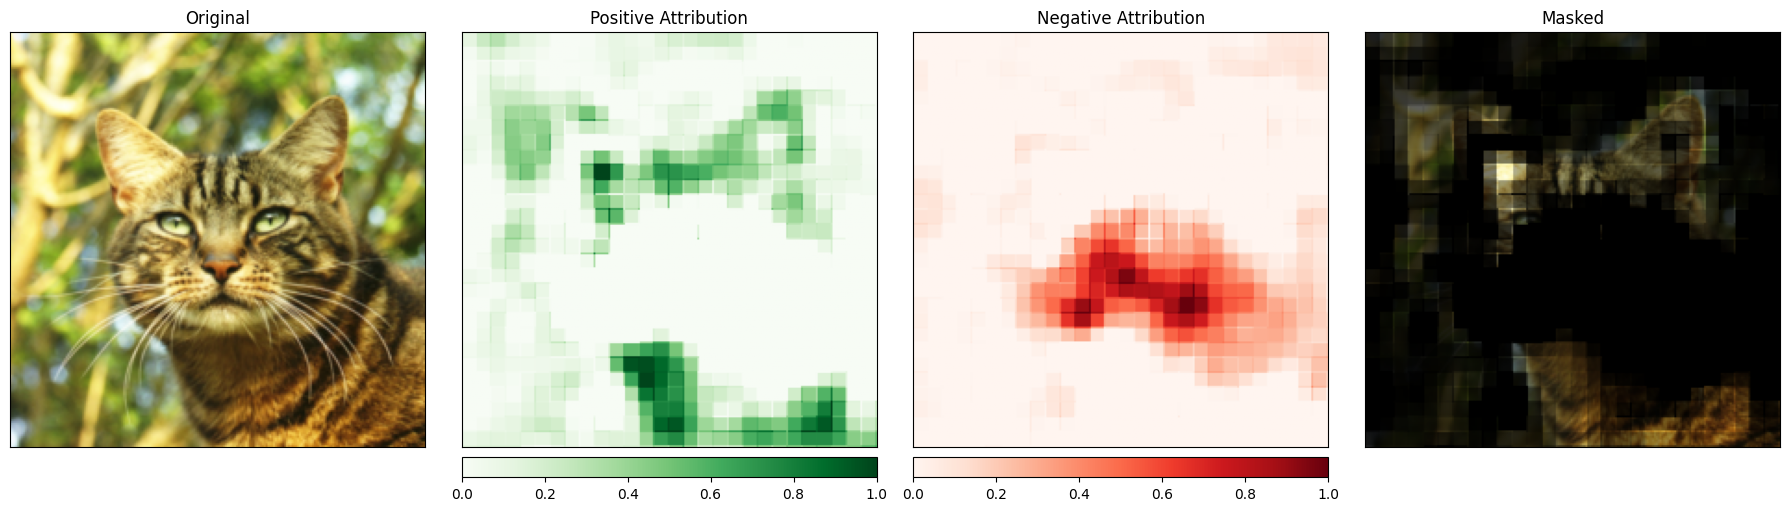

In [15]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input_img,
    target=pred_label_idx,
    strides=(3,8,8),
    sliding_window_shapes=(3,15,15),
    baselines=0)

_  = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
    ["original_image", "heat_map", "heat_map", "masked_image"],
    ["all", "positive", "negative", "positive"],
    show_colorbar = True,
    titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
    fig_size=(18,6)
)

## Layer attribution with Layer GradCAM

- Layer Attribution allows you to attribute the activity of hidden layers within your model to features of your input. Below, we’ll use a layer attribution algorithm to examine the activity of one of the convolutional layers within our model.

- GradCAM computes the gradients of the target output with respect to the given layer, averages for each output channel (dimension 2 of output), and multiplies the average gradient for each channel by the layer activations. The results are summed over all channels. GradCAM is designed for convnets; since the activity of convolutional layers often maps spatially to the input, GradCAM attributions are often upsampled and used to mask the input.

- Layer attribution is set up similarly to input attribution, except that in addition to the model, you must specify a hidden layer within the model that you wish to examine. As above, when we call attribute(), we specify the target class of interest.

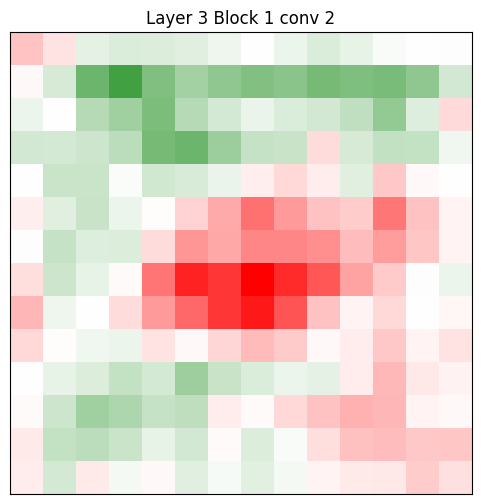

In [17]:
layer_gradcam = LayerGradCam(model, model.layer3[1].conv2)
attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)

_ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
    sign="all",
    title="Layer 3 Block 1 conv 2")

- We’ll use the convenience method interpolate() in the LayerAttribution base class to upsample this attribution data for comparison to the input image.



torch.Size([1, 1, 14, 14])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


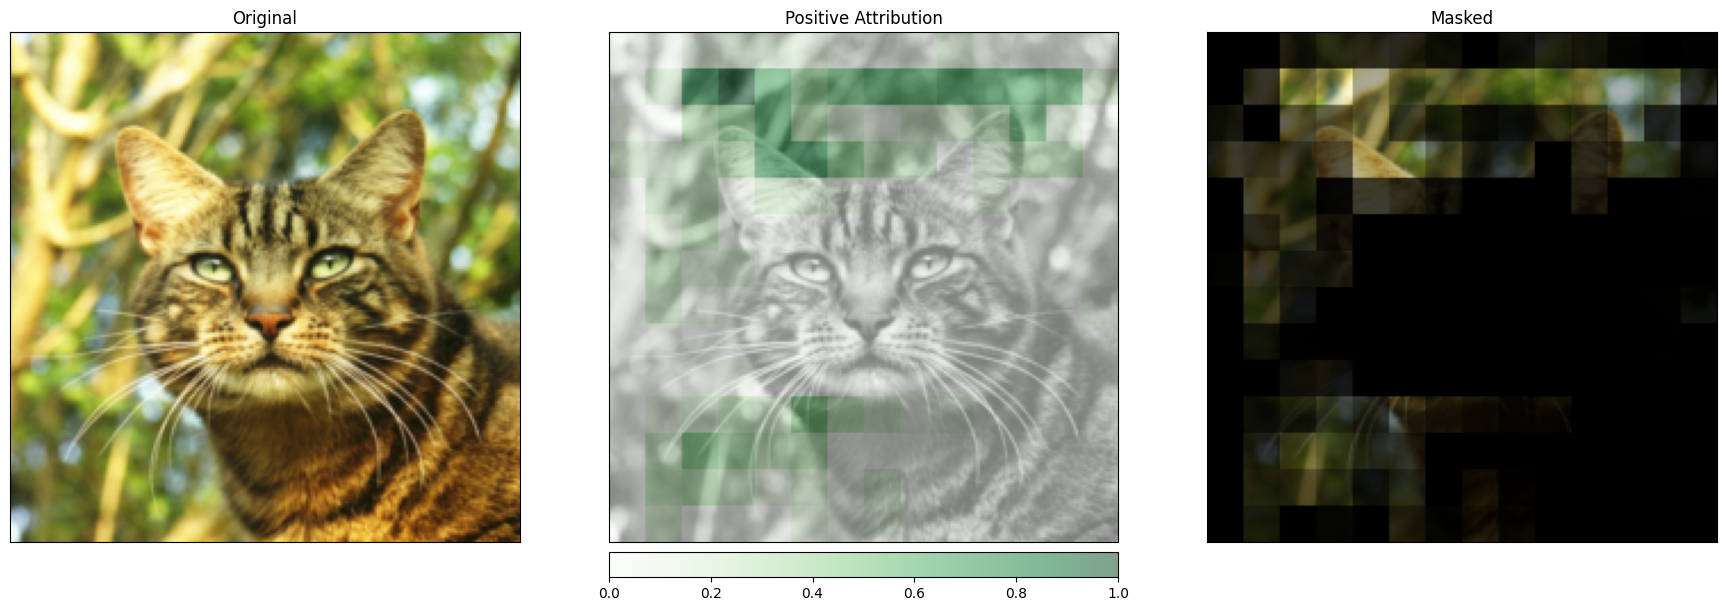

In [20]:
upsample_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

print(attributions_lgc.shape)
print(upsample_attr_lgc.shape)
print(input_img.shape)

_ = viz.visualize_image_attr_multiple(
    upsample_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
    transformed_img.permute(1,2,0).numpy(),
    ["original_image", "blended_heat_map", "masked_image"],
    ["all", "positive", "positive"],
    show_colorbar = True,
    titles = ["Original", "Positive Attribution", "Masked"],
    fig_size=(18,6)
)

## Visualization With Captum Insights

- Captum Insights is an interpretability visualization widget built on top of Captum to facilitate model understanding. Captum Insights works across images, text, and other features to help users understand feature attribution. It allows you to visualize attribution for multiple input/output pairs, and provides visualization tools for image, text, and arbitrary data.


In [21]:
imgs = ['img/cat.jpg', 'img/teapot.jpg', 'img/trilobite.jpg']

for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
    print('Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')

Predicted: tabby / 281  ( 0.5688215494155884 )
Predicted: teapot / 849  ( 0.9914798736572266 )
Predicted: trilobite / 69  ( 0.9999065399169922 )


- the Captum Insights widget, which we configure with an AttributionVisualizer object, imported below. The AttributionVisualizer expects batches of data, so we’ll bring in Captum’s Batch helper class. And we’ll be looking at images specifically, so well also import ImageFeature.

We configure the AttributionVisualizer with the following arguments:

- An array of models to be examined (in our case, just the one)

- A scoring function, which allows Captum Insights to pull out the top-k predictions from a model

- An ordered, human-readable list of classes our model is trained on

- A list of features to look for - in our case, an ImageFeature

- A dataset, which is an iterable object returning batches of inputs and labels - just like you’d use for training

In [22]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

# Baseline is all-zeros input -> this may differ depending on your data
def baseline_func(input):
    return input * 0

# merging our image transforms from above
def full_img_transform(input):
    i = Image.open(input)
    i = transform(i)
    i = transform_normalize(i)
    i = i.unsqueeze(0)
    return i


input_imgs = torch.cat(list(map(lambda i: full_img_transform(i), imgs)), 0)

visualizer = AttributionVisualizer(
    models = [model],
    score_func = lambda o: torch.nn.functional.softmax(o,1),
    classes = list(map(lambda k: idx_to_labels[k][1], idx_to_labels.keys())),
    features = [
        ImageFeature(
            "Photo",
            baseline_transforms = [baseline_func],
            input_transforms = [],
        )
    ],
    dataset = [Batch(input_imgs, labels=[282,849,69])]
)

In [27]:
%pip install --upgrade pip setuptools wheel
%pip install captum[insights]
%pip install notebook ipywidgets


Note: you may need to restart the kernel to use updated packages.
zsh:1: no matches found: captum[insights]
Note: you may need to restart the kernel to use updated packages.
  Using cached jupyterlab_server-2.27.3-py3-none-any.whl.metadata (5.9 kB)
  Using cached notebook_shim-0.2.4-py3-none-any.whl.metadata (4.0 kB)
  Using cached argon2_cffi-25.1.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached jupyter_events-0.12.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached jupyter_server_terminals-0.5.3-py3-none-any.whl.metadata (5.6 kB)
  Using cached nbconvert-7.16.6-py3-none-any.whl.metadata (8.5 kB)
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached overrides-7.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached Send2Trash-1.8.3-py3-none-any.whl.metadata (4.0 kB)
  Using cached terminado-0.18.1-py3-none-any.whl.metadata (5.8 kB)
  Using cached websocket_client-1.8.0-py3-none-any.whl.metadata (8.0 kB)
  Using cached async_lru-2.0.5-py3-none-any.whl.metad

In [30]:
visualizer.render()

CaptumInsights(insights_config={'classes': ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhe…

Output()